In [70]:
import pandas as pd
from Forecast import Forecast
import matplotlib.pyplot as plt

In [6]:
time_entries = pd.read_csv('../data/harvest/time_entries.csv', 
                           index_col='id',
                           parse_dates=['created_at', 'spent_date', 'updated_at',
                                        'task_assignment.created_at', 'task_assignment.updated_at', 
                                        'user_assignment.created_at', 'user_assignment.updated_at'],
                           infer_datetime_format=True)

# remove empty columns
time_entries.dropna(axis=1, inplace=True)

time_entries.loc[time_entries['user.name']=='Evelina Gabasova', ['project.name','client.name','task.name','spent_date','hours']]

,project.name,client.name,task.name,spent_date,hours
id,,,,,
976618782,Professional development,Hut 23,Attend conference,2019-04-05,8.0
976618666,Professional development,Hut 23,Attend conference,2019-04-04,8.0
977753610,Professional development,Hut 23,Conferences and seminars,2019-04-02,2.0
977753438,NATS,Data-centric engineering,Programming,2019-04-02,6.0
976618223,NATS,Data-centric engineering,Programming,2019-04-01,4.0
976618049,NATS,Data-centric engineering,Project Management,2019-04-01,4.0
976617663,NATS,Data-centric engineering,Programming,2019-03-29,8.0
976617574,NATS,Data-centric engineering,Programming,2019-03-28,8.0
976617490,NATS,Data-centric engineering,Programming,2019-03-27,8.0


In [51]:
time_entries.loc[time_entries['project.name']=='AIDA', 'project.id']

id
976540989    18644291
974738325    18644291
976631713    18644291
976540596    18644291
970829809    18644291
970996179    18644291
970996176    18644291
970829602    18644291
974736616    18644291
970995825    18644291
970995819    18644291
970828367    18644291
974736380    18644291
970994933    18644291
970828126    18644291
970993869    18644291
970993868    18644291
970828021    18644291
970827816    18644291
969465993    18644291
969465986    18644291
970827709    18644291
969465991    18644291
969465984    18644291
970827600    18644291
969465989    18644291
967066292    18644291
969465794    18644291
967066113    18644291
963892029    18644291
               ...   
863739478    18644291
936186898    18644291
936186787    18644291
936186723    18644291
936186655    18644291
936186589    18644291
936186528    18644291
936186426    18644291
936186382    18644291
936186347    18644291
936197236    18644291
936186247    18644291
936186130    18644291
936186066    18644291
9361860

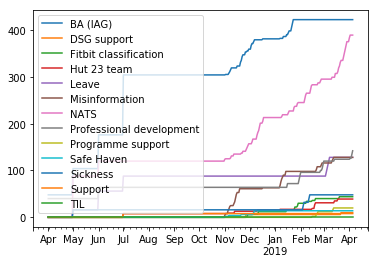

In [49]:
grouped_entries = time_entries.groupby(['user.name','project.name','spent_date']).hours.sum()

date_range = pd.date_range(start=time_entries['spent_date'].min(),
                           end=time_entries['spent_date'].max(),
                           freq='D')

entries = {}

id_values = time_entries['user.name'].unique()
ref_column = 'project.name'

for idx in id_values:
    # check whether the this id has any assignments, i.e. whether the id
    # exists in the index (get_level_values to deal with MultiIndex)
    if idx in grouped_entries.index.get_level_values(0):
        # get the entries
        id_entries = grouped_entries.loc[idx]

        # unstack the MultiIndex
        id_entries = id_entries.reset_index()

        # Initialise dataframe to store results
        id_entries_days = pd.DataFrame(index=date_range, columns=id_entries[ref_column].unique())
        id_entries_days.fillna(0, inplace=True)

        # Loop over each assignment
        for _, row in id_entries.iterrows():
            # Add the allocation to the corresponding project for the range of dates.
            id_entries_days.loc[row['spent_date'], row[ref_column]] += row['hours']

    else:
        # no projects, just make an empty dataframe
        id_entries_days = pd.DataFrame(index=date_range)

    entries[idx] = id_entries_days

entries['Evelina Gabasova'].resample('MS').sum()
entries['Evelina Gabasova'].cumsum().plot()

In [67]:
nats_harvest = entries['Evelina Gabasova']['NATS']

2018-04-01    0.0
2018-04-02    0.0
2018-04-03    0.0
2018-04-04    0.0
2018-04-05    0.0
2018-04-06    0.0
2018-04-07    0.0
2018-04-08    0.0
2018-04-09    0.0
2018-04-10    0.0
2018-04-11    0.0
2018-04-12    0.0
2018-04-13    0.0
2018-04-14    0.0
2018-04-15    0.0
2018-04-16    0.0
2018-04-17    0.0
2018-04-18    0.0
2018-04-19    0.0
2018-04-20    0.0
2018-04-21    0.0
2018-04-22    0.0
2018-04-23    0.0
2018-04-24    0.0
2018-04-25    0.0
2018-04-26    0.0
2018-04-27    0.0
2018-04-28    0.0
2018-04-29    0.0
2018-04-30    0.0
             ... 
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    4.0
2019-03-12    0.0
2019-03-13    0.0
2019-03-14    0.0
2019-03-15    8.0
2019-03-16    0.0
2019-03-17    0.0
2019-03-18    4.0
2019-03-19    8.0
2019-03-20    4.0
2019-03-21    8.0
2019-03-22    4.0
2019-03-23    0.0
2019-03-24    0.0
2019-03-25    8.0
2019-03-26    8.0
2019-03-27    8.0
2019-03-28    8.0
2019-03-29    8.0
2019-03-30    0.0
2019-03-31

In [62]:
fc = Forecast()
nats_forecast = fc.people_allocations[fc.get_person_id('Evelina','Gabasova')][fc.get_project_id('NATS')]
nats_forecast = nats_forecast.resample('W-MON').mean() * 5

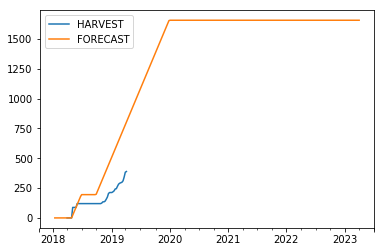

In [74]:
nats_harvest.resample('W-MON').sum().cumsum().plot(label='HARVEST')
(nats_forecast*6.4).cumsum().plot(label='FORECAST')
plt.legend()

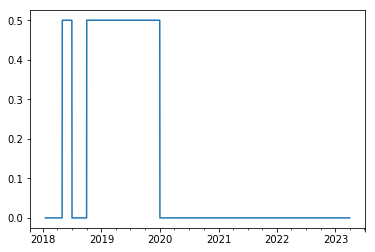

In [78]:
nats_forecast.plot()

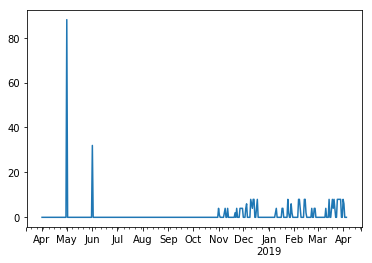

In [77]:
nats_harvest.plot()

## Excluding weekends and public holidays

In [81]:
pd.tseries.offsets.BDay()

<BusinessDay>

In [82]:
pd.date_range('2019-03-01','2019-04-01', freq=pd.tseries.offsets.BDay())

DatetimeIndex(['2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06',
               '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18',
               '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-04-01'],
              dtype='datetime64[ns]', freq='B')

In [106]:
#!pip install holidays
import holidays

uk_holidays = holidays.England()

pd.datetime(2023,8,28) in uk_holidays

tmp = pd.date_range('2019-01-01','2019-12-31')
print('all days',len(tmp))

tmp = pd.date_range('2019-01-01','2019-12-31', freq=pd.tseries.offsets.BDay())
print('weekdays',len(tmp))

tmp = pd.date_range('2019-01-01','2019-12-31', freq=pd.tseries.offsets.BDay())
tmp = [x for x in tmp if x not in uk_holidays]
print('business days',len(tmp))

tmp = pd.to_datetime(tmp)

all days 365
weekdays 261
business days 253


In [118]:
df = pd.DataFrame(index=tmp)
df['o'] = 1 
df.resample('W-MON').mean()

,o
2019-01-07,1
2019-01-14,1
2019-01-21,1
2019-01-28,1
2019-02-04,1
2019-02-11,1
2019-02-18,1
2019-02-25,1
2019-03-04,1
2019-03-11,1
